In [2]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [4]:
FILE_PATH = "/content/trajectory_lstm_dataset.csv"
N_STEPS = 5

FEATURES = ['lat', 'lon', 'speed_m_s', 'direction_rad']
TARGETS = ['lat_next', 'lon_next']
ALL_COLS = FEATURES + TARGETS

df = pd.read_csv(FILE_PATH)
data_to_scale = df[ALL_COLS].copy()

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data_to_scale)
scaled_df = pd.DataFrame(scaled_data, columns=ALL_COLS)

def create_sequences(df, N_STEPS, features, targets):
    X, y = [], []
    feature_indices = [df.columns.get_loc(col) for col in features]
    target_indices = [df.columns.get_loc(col) for col in targets]
    data_array = df.values
    num_rows = len(data_array)
    for i in range(num_rows - N_STEPS):
        X_data = data_array[i : i + N_STEPS, feature_indices]
        X.append(X_data)
        y_data = data_array[i + N_STEPS - 1, target_indices]
        y.append(y_data)
    return np.array(X), np.array(y)

In [5]:
X_scaled, y_scaled = create_sequences(scaled_df, N_STEPS, FEATURES, TARGETS)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled,
    y_scaled,
    test_size=0.2,
    shuffle=False
)

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")

X_train shape: (235, 5, 4)
X_test shape: (59, 5, 4)


In [6]:
N_FEATURES = X_train.shape[2]
N_OUTPUTS = y_train.shape[1]

model = Sequential([
    LSTM(units=50, activation='relu', input_shape=(N_STEPS, N_FEATURES)),
    Dense(units=N_OUTPUTS)
])

model.compile(optimizer='adam', loss='mse')

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50)             │        11,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2)              │           102 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,102 (43.37 KB)

 Trainable params: 11,102 (43.37 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
history = model.fit(
    X_train,
    y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.1
)

Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - loss: 0.1948 - val_loss: 0.1152
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1044 - val_loss: 0.0677
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0522 - val_loss: 0.0526
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0361 - val_loss: 0.0588
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0368 - val_loss: 0.0518
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0314 - val_loss: 0.0449
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0293 - val_loss: 0.0397
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0253 - val_loss: 0.0336
Epoch 9/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0229 - val_loss: 0.0306
Epoch 10/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0202 - val_loss: 0.0271
Epoch 11/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0171 - val_loss: 0.0214
Epoch 12/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0159 - val_loss: 0.0172
E

In [8]:
loss = model.evaluate(X_test, y_test, verbose=0)
print(f"Loss (MSE) en el conjunto de prueba: {loss:.6f}")

y_pred_scaled = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred_scaled)
mae = mean_absolute_error(y_test, y_pred_scaled)

print(f"Mean Squared Error (MSE): {mse:.6f}")
print(f"Mean Absolute Error (MAE): {mae:.6f}")

Loss (MSE) en el conjunto de prueba: 0.012114
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 442ms/step
Mean Squared Error (MSE): 0.012114
Mean Absolute Error (MAE): 0.087070


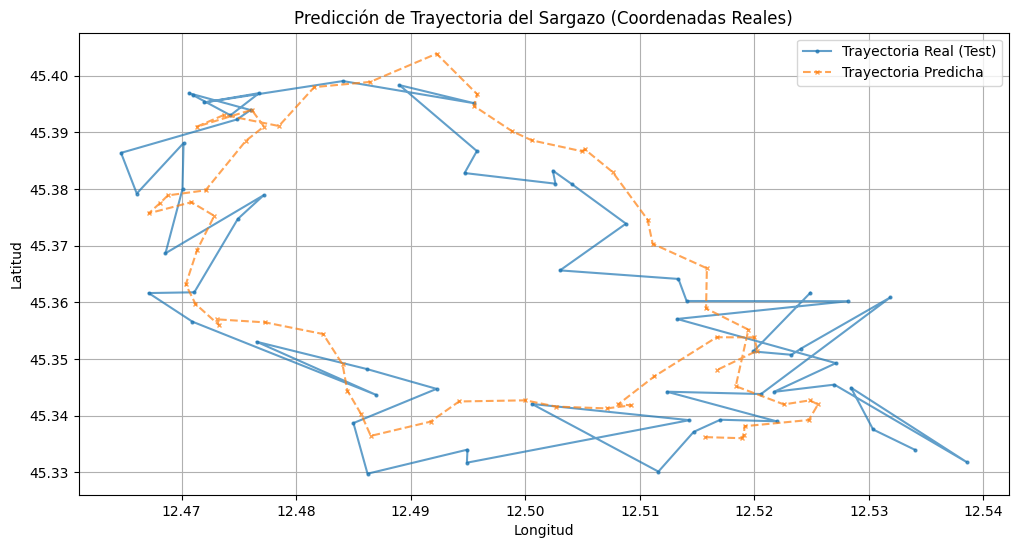

In [10]:
# The 'scaler' was fitted on ALL_COLS, which has 6 features. y_pred_scaled and y_test only have 2 features.
# To inverse transform correctly, we need to create a temporary array with 6 features.

# Indices of lat_next and lon_next within ALL_COLS
lat_next_idx = ALL_COLS.index('lat_next')
lon_next_idx = ALL_COLS.index('lon_next')

# --- Inverse transform y_pred_scaled ---
# Create a dummy array for predictions with the full number of columns the scaler expects
dummy_pred_for_inverse = np.zeros((y_pred_scaled.shape[0], len(ALL_COLS)))
# Place the scaled predictions (lat_next, lon_next) into their respective columns
dummy_pred_for_inverse[:, lat_next_idx] = y_pred_scaled[:, 0] # y_pred_scaled[:, 0] is scaled lat_next
dummy_pred_for_inverse[:, lon_next_idx] = y_pred_scaled[:, 1] # y_pred_scaled[:, 1] is scaled lon_next

# Inverse transform the dummy array to get real-valued predictions for all features
inverted_pred_full = scaler.inverse_transform(dummy_pred_for_inverse)

# Extract the real-valued predicted lat_next and lon_next
lat_pred = inverted_pred_full[:, lat_next_idx]
lon_pred = inverted_pred_full[:, lon_next_idx]

# --- Inverse transform y_test (actual scaled values) ---
# Create a dummy array for actual test values with the full number of columns the scaler expects
dummy_test_for_inverse = np.zeros((y_test.shape[0], len(ALL_COLS)))
# Place the scaled actual values (lat_next, lon_next) into their respective columns
dummy_test_for_inverse[:, lat_next_idx] = y_test[:, 0] # y_test[:, 0] is scaled lat_next
dummy_test_for_inverse[:, lon_next_idx] = y_test[:, 1] # y_test[:, 1] is scaled lon_next

# Inverse transform the dummy array to get real-valued actuals for all features
inverted_test_full = scaler.inverse_transform(dummy_test_for_inverse)

# Extract the real-valued actual lat_next and lon_next
lat_actual = inverted_test_full[:, lat_next_idx]
lon_actual = inverted_test_full[:, lon_next_idx]

# Graficando las trayectorias
plt.figure(figsize=(12, 6))
plt.plot(lon_actual, lat_actual, label='Trayectoria Real (Test)', marker='o', linestyle='-', markersize=2, alpha=0.7)
plt.plot(lon_pred, lat_pred, label='Trayectoria Predicha', marker='x', linestyle='--', markersize=3, alpha=0.7)
plt.title('Predicción de Trayectoria del Sargazo (Coordenadas Reales)')
plt.xlabel('Longitud')
plt.ylabel('Latitud')
plt.legend()
plt.grid(True)
plt.show()

In [12]:
y_pred_scaled = model.predict(X_test)

# The inverse transformation has already been correctly performed in the previous cell
# and the variables lat_actual, lon_actual, lat_pred, lon_pred are available.
# Removing the erroneous re-transformation lines from here.

results_df = pd.DataFrame({
    'Latitud Real': lat_actual,
    'Longitud Real': lon_actual,
    'Latitud Predicha': lat_pred,
    'Longitud Predicha': lon_pred
})

print("Primeros 10 Resultados del Conjunto de Prueba:")
print(results_df.head(10).to_markdown(index=False, numalign="left", stralign="left"))

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Primeros 10 Resultados del Conjunto de Prueba:
| Latitud Real   | Longitud Real   | Latitud Predicha   | Longitud Predicha   |
|:---------------|:----------------|:-------------------|:--------------------|
| 45.334         | 12.534          | 45.3362            | 12.5157             |
| 45.3375        | 12.5304         | 45.336             | 12.5189             |
| 45.3449        | 12.5284         | 45.3366            | 12.5191             |
| 45.3318        | 12.5385         | 45.3381            | 12.5191             |
| 45.3455        | 12.527          | 45.3392            | 12.5248             |
| 45.3442        | 12.5217         | 45.342             | 12.5256             |
| 45.3493        | 12.5271         | 45.3427            | 12.5248             |
| 45.3571        | 12.5133         | 45.342             | 12.5226             |
| 45.3602        | 12.5282         | 45.3452            | 12.5184             |
| 45.3602        | 12.5141         

In [13]:
import pickle
import json
import zipfile
from google.colab import files

# ================================
# VARIABLES GLOBALES DE CONFIGURACIÓN (de pasos anteriores)
# Estas variables deben existir antes de esta celda
# ================================
# model # El modelo LSTM entrenado
# scaler # El objeto MinMaxScaler ajustado
# FEATURES # ['lat', 'lon', 'speed_m_s', 'direction_rad']
# TARGETS # ['lat_next', 'lon_next']
# N_STEPS # 3

# ================================
# GUARDAR MODELO
# ================================
model.save("sargazo_lstm_model.h5")

# ================================
# GUARDAR SCALER
# ================================
with open("sargazo_scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)

# ================================
# GUARDAR CONFIG
# ================================
config = {
    "N_STEPS": N_STEPS,
    "FEATURES": FEATURES,
    "TARGETS": TARGETS,
    "ALL_COLS": ALL_COLS
}

with open("sargazo_config.json", "w") as f:
    json.dump(config, f, indent=4)

# ================================
# CREAR ZIP CON TODO
# ================================
zip_filename = "sargazo_prediction_backend.zip"

with zipfile.ZipFile(zip_filename, "w") as zipf:
    zipf.write("sargazo_lstm_model.h5")
    zipf.write("sargazo_scaler.pkl")
    zipf.write("sargazo_config.json")

# ================================
# DESCARGAR ZIP
# ================================
files.download(zip_filename)

print("Todo listo. El archivo ZIP 'sargazo_prediction_backend.zip' ha sido generado y se ha iniciado la descarga.")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Todo listo. El archivo ZIP 'sargazo_prediction_backend.zip' ha sido generado y se ha iniciado la descarga.


implementacion


In [ ]:
import numpy as np
import pickle
import json
import pandas as pd
from tensorflow.keras.models import load_model

class SargazoPredictor:
    """
    Clase que encapsula la lógica para cargar el modelo, escalador y configuración,
    y realizar la predicción de la siguiente posición del sargazo.
    """
    def __init__(self, model_path, scaler_path, config_path):
        self.model_path = model_path
        self.scaler_path = scaler_path
        self.config_path = config_path
        self._load_components()

    def _load_components(self):
        """Carga el modelo Keras, el MinMaxScaler y los parámetros de configuración."""
        try:
            # 1. Cargar Configuración
            with open(self.config_path, 'r') as f:
                self.config = json.load(f)
            self.N_STEPS = self.config['N_STEPS']
            self.FEATURES = self.config['FEATURES']
            self.TARGETS = self.config['TARGETS']
            self.ALL_COLS = self.config['ALL_COLS']

            # 2. Cargar Escalador
            with open(self.scaler_path, 'rb') as f:
                self.scaler = pickle.load(f)

            # 3. Cargar Modelo
            self.model = load_model(self.model_path)

            # Índices necesarios para revertir el escalado
            self.lat_next_idx = self.ALL_COLS.index('lat_next')
            self.lon_next_idx = self.ALL_COLS.index('lon_next')

            print("Componentes de predicción cargados. Listo para usar.")

        except Exception as e:
            print(f"Error al cargar componentes: Asegúrese de que todos los archivos (.h5, .pkl, .json) estén presentes.")
            print(f"Detalles del error: {e}")
            raise

    def preprocess_sequence(self, new_data_sequence):
        """
        Escala y da la forma correcta a la nueva secuencia de entrada (N_STEPS, N_FEATURES).
        """
        new_data_array = np.array(new_data_sequence)

        if new_data_array.shape != (self.N_STEPS, len(self.FEATURES)):
            raise ValueError(f"La secuencia de entrada debe tener la forma ({self.N_STEPS}, {len(self.FEATURES)}). Se recibió {new_data_array.shape}.")

        # 1. Crear un DataFrame dummy con todas las columnas usadas en el escalado (FEATURES + TARGETS)
        # Esto es crucial porque el MinMaxScaler fue ajustado sobre 'ALL_COLS'.
        dummy_data = np.zeros((self.N_STEPS, len(self.ALL_COLS)))

        # 2. Colocar los datos de entrada en las columnas de FEATURES
        for i, col in enumerate(self.FEATURES):
            col_index_in_all = self.ALL_COLS.index(col)
            dummy_data[:, col_index_in_all] = new_data_array[:, i]

        # 3. Escalar los datos
        scaled_dummy = self.scaler.transform(dummy_data)

        # 4. Extraer solo las features escaladas y dar la forma para el modelo (1, N_STEPS, N_FEATURES)
        scaled_features = scaled_dummy[:, :len(self.FEATURES)]
        return scaled_features.reshape(1, self.N_STEPS, len(self.FEATURES))

    def predict_next_position(self, scaled_input):
        """
        Realiza la predicción del modelo y revierte el escalado para obtener coordenadas reales.
        """
        # 1. Predicción del modelo (salida escalada)
        scaled_prediction = self.model.predict(scaled_input)[0]

        # 2. Revertir Escalado (necesita el array completo de ALL_COLS)
        dummy_inverse = np.zeros((1, len(self.ALL_COLS)))

        # Colocar la predicción en las posiciones de TARGETS ('lat_next', 'lon_next')
        dummy_inverse[0, self.lat_next_idx] = scaled_prediction[0]
        dummy_inverse[0, self.lon_next_idx] = scaled_prediction[1]

        # Revertir la transformación
        real_prediction_all_cols = self.scaler.inverse_transform(dummy_inverse)

        # Extraer solo lat_next y lon_next reales
        lat_pred_real = real_prediction_all_cols[0, self.lat_next_idx]
        lon_pred_real = real_prediction_all_cols[0, self.lon_next_idx]

        return {
            'latitud_siguiente': float(lat_pred_real),
            'longitud_siguiente': float(lon_pred_real)
        }

# =======================================================
# USO EN SU BACKEND/OTRO AMBIENTE
# =======================================================
if __name__ == '__main__':

    # 1. Inicializar el predictor
    try:
        predictor = SargazoPredictor(
            model_path='sargazo_lstm_model.h5',
            scaler_path='sargazo_scaler.pkl',
            config_path='sargazo_config.json'
        )
    except:
        print("\nERROR: No se pudo inicializar el predictor. Asegúrese de que los archivos se descomprimieron correctamente en este directorio.")
        exit()

    # 2. Datos de ENTRADA: La secuencia de los ÚLTIMOS N_STEPS (3) pasos
    # DEBEN ser 3 filas, cada una con [lat, lon, speed_m_s, direction_rad]

    # **Ejemplo usando los primeros 3 puntos de su dataset original:**
    nueva_secuencia = [
        [45.362174, 12.530910, 0.000000, 0.000000],  # Paso t-2
        [45.380659, 12.532465, 2059.128646, 1.486900], # Paso t-1
        [45.375743, 12.519440, 1545.373286, -2.780673]  # Paso t
    ]

    print(f"\nSecuencia de entrada de {predictor.N_STEPS} pasos:\n", np.array(nueva_secuencia))

    # 3. Preprocesar y Predecir
    try:
        scaled_input = predictor.preprocess_sequence(nueva_secuencia)
        resultado_prediccion = predictor.predict_next_position(scaled_input)

        print("\n--- Resultado de la Predicción (t+1) ---")
        print(f"La siguiente posición predicha es:")
        print(f"  Latitud: {resultado_prediccion['latitud_siguiente']:.6f}")
        print(f"  Longitud: {resultado_prediccion['longitud_siguiente']:.6f}")

    except Exception as e:
        print(f"\nError durante la predicción: {e}")